In [1]:
import scipy.io
import jax.numpy as np
from scipy.io import loadmat 
import numpy as onp
import matplotlib.pyplot as plt 
import os
import shutil
from PIL import Image
from inrmri.bart import bart_acquisition_from_arrays
from inrmri.data_harvard import get_csmaps_and_mask, get_reference_reco
import pandas as pd
from jax import jit, vmap, random
from inrmri.dip import TimeDependant_DIP_Net, helix_generator, circle_generator
from inrmri.new_radon import ForwardRadonOperator
from inrmri.fourier import fastshiftfourier, get_freqs
from inrmri.basic_nn import weighted_loss 
from inrmri.utils import to_complex, is_inside_of_radial_lim, meshgrid_from_subdiv_autolims, total_variation_batch_complex, save_matrix_and_dict_in_zpy, load_matrix_and_dict_from_zpy    
from inrmri.utils import create_exp_file_name, total_variation_complex
import optax 
from inrmri.metrics_rd import mean_psnr, mean_ssim, mean_artifact_power
from inrmri.utils_rdls import seconds_to_min_sec_format, filter_and_get_columns, apply_transform

from inrmri.utils_rdls import get_info_volunteer, read_segmentation, read_ref_dataset

In [2]:
from inrmri.image_processor import BeforeLinRegNormalizer
from inrmri.basic_plotting import full_halph_FOV_space_time 
from inrmri.image_processor import reduce_FOV 

In [3]:
from inrmri.utils_rdls import safe_normalize, get_center

## General

In [4]:
total_slices = 8
num_frames   = 30
dataset        = 'DATA_0.55T'
volunteer      = 'FB'
slice_num             = 1
base_path    = '/mnt/workspace/datasets/pulseqCINE/'
stdip_parameters = {
    'experiment_name': 'iter_lr_init_value', 
    'training_params': {
        'iter':2000,
        'lr_init_value': 1e-3,
        'slice':slice_num,
    }
}
tddip_parameters = {
    'experiment_name': 'iter_lr_init_value', 
    'training_params': {
        'iter':2000,
        'lr_init_value': 1e-3,
        'slice':slice_num,
    }
}
# parameteres for global statustics
stdip_summray_parameters = stdip_parameters['training_params']
stdip_summray_parameters.pop('slice', None)
tddip_summray_parameters = tddip_parameters['training_params']
tddip_summray_parameters.pop('slice', None)

1

In [5]:
# === Volunteer and Training Parameters ===
volunteer_params = get_info_volunteer(dataset, volunteer, slice_num)
volunteer_params

{'crop_ns': [15, 55, 35, 40],
 'saturation': 0.2,
 'trans': {'flip_h': False, 'flip_v': False, 'rot': 0},
 'EF_frames': {'EDV_gt': 0, 'ESV_gt': 8, 'EDV': 0, 'ESV': 8},
 'trans_gt': {'flip_h': False, 'flip_v': False, 'rot': 180}}

# 1 .- Define volunteer and experiment

In [6]:
# --- PATH ---
base_folder                = base_path + dataset + '/' + volunteer + '/'
train_data_folder          = base_folder + 'traindata/'

## 1.1 .- Ground truth data

In [7]:
total_time_grasp = 0
total_time_sense = 0
for i in range(total_slices):
    slice_item = i+1
    dataset_name       = 'slice_' + str(slice_item) + '_' + str(total_slices) +'_nbins' + str(num_frames)
    path_dataset       = train_data_folder + dataset_name + '.npz'
    data               = onp.load(path_dataset)
    total_time_grasp   += data["time_grasp"]
    total_time_sense   += data["time_sense"]
total_time_grasp, total_time_sense

(np.float64(620.1941945552826), np.float64(160.01505279541016))

In [8]:
dataset_name          = 'slice_' + str(slice_num) + '_' + str(total_slices) +'_nbins' + str(num_frames)
path_dataset          = train_data_folder + dataset_name + '.npz'

In [9]:
data         = onp.load(path_dataset)
recon_grasp  = data["recon_grasp"]
recon_sense  = data["recon_sense"]
recon_fs     = data["recon_fs"]
time_grasp   = data["time_grasp"]
time_sense   = data["time_sense"]

recon_grasp    = get_center(recon_grasp) 
recon_sense    = get_center(recon_sense)
recon_fs       = get_center(recon_fs) 

recon_grasp    = safe_normalize(recon_grasp) 
recon_sense    = safe_normalize(recon_sense) 
recon_fs       = safe_normalize(recon_fs) 

2025-07-22 14:39:27.114617: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
reference_metrics = {
    'time_grasp':     time_grasp,
    'time_sense':     time_sense,
    'time_grasp_str': seconds_to_min_sec_format(total_time_grasp),
    'time_sense_str': seconds_to_min_sec_format(total_time_sense),
    'psnr_grasp':     mean_psnr(recon_grasp, recon_fs),
    'psnr_sense':     mean_psnr(recon_sense, recon_fs),
    'ssim_grasp':     mean_ssim(recon_grasp, recon_fs),
    'ssim_sense':     mean_ssim(recon_sense, recon_fs),
    'psnr_grasp_str':     str(round(float(mean_psnr(recon_grasp, recon_fs)),1)),
    'psnr_sense_str':     str(round(float(mean_psnr(recon_sense, recon_fs)),1)),
    'ssim_grasp_str':     str(round(float(mean_ssim(recon_grasp, recon_fs)),3)),
    'ssim_sense_str':     str(round(float(mean_ssim(recon_sense, recon_fs)),3)),
}

## 1.2 .- Models reconstructions

In [11]:
target_columns = ['training_name', 'psnr', 'ssim', 'it', 'duration [min]', 'duration [s]']

### 1.2.1 .- ST-DIP

In [12]:
stdip_parameters['path']               = base_folder + 'stDIP'
stdip_parameters['csv_path']           = stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + ".csv"
stdip_parameters['csv_path_summary']   = stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + "_summary.csv"
stdip_parameters['exp_folder_path']    = stdip_parameters['path'] +  '/' + dataset_name + '/' + stdip_parameters['experiment_name']
df_stdip                               = pd.read_csv(stdip_parameters['csv_path'] , delimiter=';')
df_stdip_summary                       = pd.read_csv(stdip_parameters['csv_path_summary'] , delimiter=';')

In [13]:
stDIP_results                          = filter_and_get_columns(df_stdip, stdip_parameters['training_params'], target_columns)[0]

In [14]:
stdip_parameters['best_recon_path']    = stdip_parameters['exp_folder_path'] +  '/' + stDIP_results['training_name'] + '/' + 'best_recon.npz'

In [15]:
stDIP_results['recon']     = onp.load(stdip_parameters['best_recon_path'], allow_pickle=True)['best_recon']

### 1.2.2 .- TD-DIP

In [16]:
tddip_parameters['path']               = base_folder + 'tdDIP'
tddip_parameters['csv_path']           = tddip_parameters['path'] +  '/' + tddip_parameters['experiment_name'] + ".csv"
tddip_parameters['csv_path_summary']   = tddip_parameters['path'] +  '/' + tddip_parameters['experiment_name'] + "_summary.csv"
tddip_parameters['exp_folder_path']    = tddip_parameters['path'] +  '/' + dataset_name + '/' + tddip_parameters['experiment_name']
df_tddip                               = pd.read_csv(tddip_parameters['csv_path'] , delimiter=';')
df_tddip_summary                       = pd.read_csv(tddip_parameters['csv_path_summary'] , delimiter=';')

In [17]:
tdDIP_results                          = filter_and_get_columns(df_tddip, tddip_parameters['training_params'], target_columns)[0]

In [18]:
tdDIP_summary_results                         =    filter_and_get_columns(df_tddip_summary, tddip_summray_parameters, ['duration [s]_mean'])[0]
tdDIP_results['total_recon_time [s]']         =    tdDIP_summary_results['duration [s]_mean'] * total_slices
tdDIP_results['total_recon_time [s]'], tdDIP_results['total_recon_time [s]']//60

(2586.317453622818, 43.0)

In [19]:
tddip_parameters['best_recon_path']    = tddip_parameters['exp_folder_path'] +  '/' + tdDIP_results['training_name'] + '/' + 'best_recon.npz'

In [20]:
tdDIP_results['recon']     = onp.load(tddip_parameters['best_recon_path'], allow_pickle=True)['best_recon']

In [21]:
stDIP_results['recon']     = safe_normalize(stDIP_results['recon'] ) 
tdDIP_results['recon']     = safe_normalize(tdDIP_results['recon'] ) 

# 2 .- Comparison of models

In [22]:
comparison_folder = base_folder + 'comparison/'
if not os.path.exists(comparison_folder):
    os.makedirs(comparison_folder)

## 2.1 .- Parameters for visualiation

In [23]:
add_psnr = False
add_ssim = False
add_time = True
gt_title    = r'$\mathbf{Ground Truth}$'
stdip_title = r'$\mathbf{ST\text{-}DIP}$'
tddip_title = r'$\mathbf{TD\text{-}DIP}$'
grasp_title = r'$\mathbf{GRASP}$'
sense_title = r'$\mathbf{SENSE}$'
if add_psnr:
    gt_title    += '\n '
    stdip_title += '\npsnr: ' + str(round(stDIP_results['psnr'],1))
    tddip_title += '\npsnr: ' + str(round(tdDIP_results['psnr'],1))
    grasp_title += '\npsnr: ' + reference_metrics['psnr_grasp_str']
    sense_title += '\npsnr: ' + reference_metrics['psnr_sense_str']

if add_ssim:
    gt_title    += '\n '
    stdip_title += '\nssim: ' + str(round(stDIP_results['ssim'],3))
    tddip_title += '\nssim: ' + str(round(tdDIP_results['ssim'],3))
    grasp_title += '\nssim: ' + reference_metrics['ssim_grasp_str']
    sense_title += '\nssim: ' + reference_metrics['ssim_sense_str']

if add_time:
    gt_title    += '\n '
    stdip_title += '\ntotal recon time: ' + seconds_to_min_sec_format(stDIP_results['duration [s]'])
    tddip_title += '\ntotal recon time: ' + seconds_to_min_sec_format(tdDIP_results['total_recon_time [s]'])
    grasp_title += '\ntotal recon time: ' + reference_metrics['time_grasp_str']
    sense_title += '\ntotal recon time: ' + reference_metrics['time_sense_str']

In [24]:
stDIP_results['name'] = stdip_title
tdDIP_results['name'] = tddip_title
name_grasp            = grasp_title
name_sense            = sense_title

## 2.2 .- Plotting customization per volunteer

In [25]:
volunteer_params

{'crop_ns': [15, 55, 35, 40],
 'saturation': 0.2,
 'trans': {'flip_h': False, 'flip_v': False, 'rot': 0},
 'EF_frames': {'EDV_gt': 0, 'ESV_gt': 8, 'EDV': 0, 'ESV': 8},
 'trans_gt': {'flip_h': False, 'flip_v': False, 'rot': 180}}

In [26]:
stDIP_results['recon_trans'] = apply_transform(stDIP_results['recon'], volunteer_params['trans'])
tdDIP_results['recon_trans'] = apply_transform(tdDIP_results['recon'], volunteer_params['trans'])
recon_grasp_trans = apply_transform(recon_grasp, volunteer_params['trans'])
recon_sense_trans = apply_transform(recon_sense, volunteer_params['trans'])
recon_fs_trans = apply_transform(recon_fs, volunteer_params['trans_gt'])

In [27]:
matrix_list  = [recon_fs_trans, stDIP_results['recon_trans'], tdDIP_results['recon_trans'] , recon_grasp_trans, recon_sense_trans]
matrix_names = [gt_title, stDIP_results['name'], tdDIP_results['name'] , name_grasp , name_sense ]

crop_ns       = volunteer_params['crop_ns']
saturation    = volunteer_params['saturation']
frame = 0
print(crop_ns, saturation)

[15, 55, 35, 40] 0.2


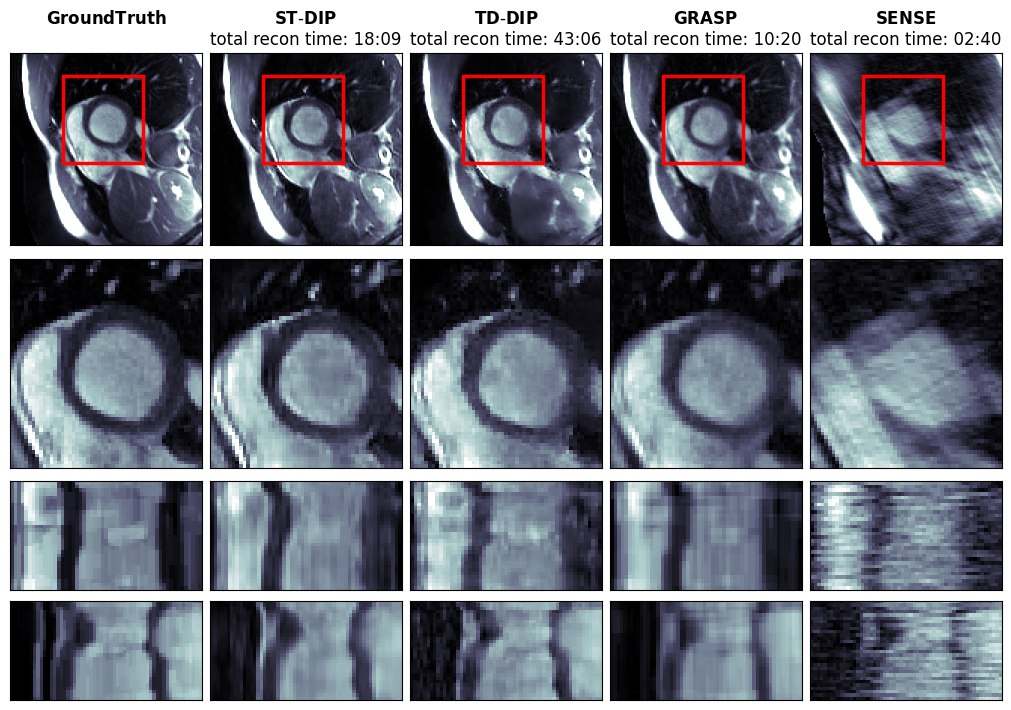

In [28]:
fig, axs = full_halph_FOV_space_time(matrix_list, crop_ns=crop_ns, saturation=saturation, frame=frame, xy_proportion=(2,7))
for ax, title in zip(axs, matrix_names):
    ax[0].set_title(title)
fig.savefig( comparison_folder + 'slice' + str(slice_num) + ".png", dpi=300, bbox_inches='tight')